# 1 Preperations

In [ ]:
!pip install dowhy 0>/dev/null 1>/dev/null
!pip install econml 0>/dev/null 1>/dev/null

In [ ]:
import pandas as pd
import numpy as np
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io
from dowhy import CausalModel
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import LearningRateScheduler, Callback
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from google.colab import files
from google.colab import drive
import os
import glob

In [ ]:
!pip install pandas numpy scikit-learn tensorflow matplotlib 0> /dev/null 1> /dev/null
drive.mount('/content/drive',force_remount=True)
if not os.path.exists("/content/Data/"):
  print("Copying the CSV files from google drive")
  os.makedirs("/content/Data/")
  !ls "/content/drive/MyDrive/Visualization/data/csv" | xargs -I {} cp "/content/drive/MyDrive/Visualization/data/csv/"{} /content/Data/
  print("Files uploaded:")
  !ls /content/Data/
print("Reading the CSV files")
csv_files = glob.glob(f"/content/Data/*.csv")
print("\nCombining all uploaded files into a single DataFrame...")
combined_df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
combined_df = combined_df.replace([np.inf, -np.inf], np.nan)
combined_df.dropna(how='any', inplace=True)
print(combined_df.head())
combined_df = combined_df.drop(columns=['Unnamed: 0'], axis=1)
print("\nCombined DataFrame:")
print(combined_df.head())

# Save to a new CSV (optional)
combined_df.to_csv('combined_dataset1.csv', index=False)


Mounted at /content/drive
Reading the CSV files

Combining all uploaded files into a single DataFrame...
   Unnamed: 0  TBS  SegmentsNum  SegmentDelay(noSched_noFrame)
0           0   24            1                       6.857872
1           1   24            3                       9.312153
2           2   24            1                       9.299278
3           3   24            3                       5.219698
4           4   24            2                       7.835150

Combined DataFrame:
   TBS  SegmentsNum  SegmentDelay(noSched_noFrame)
0   24            1                       6.857872
1   24            3                       9.312153
2   24            1                       9.299278
3   24            3                       5.219698
4   24            2                       7.835150


In [ ]:
data = pd.read_csv('combined_dataset1.csv')

# Display the first few rows
data.head()

,TBS,SegmentsNum,SegmentDelay(noSched_noFrame)
0,24,1,6.857872
1,24,3,9.312153
2,24,1,9.299278
3,24,3,5.219698
4,24,2,7.835150


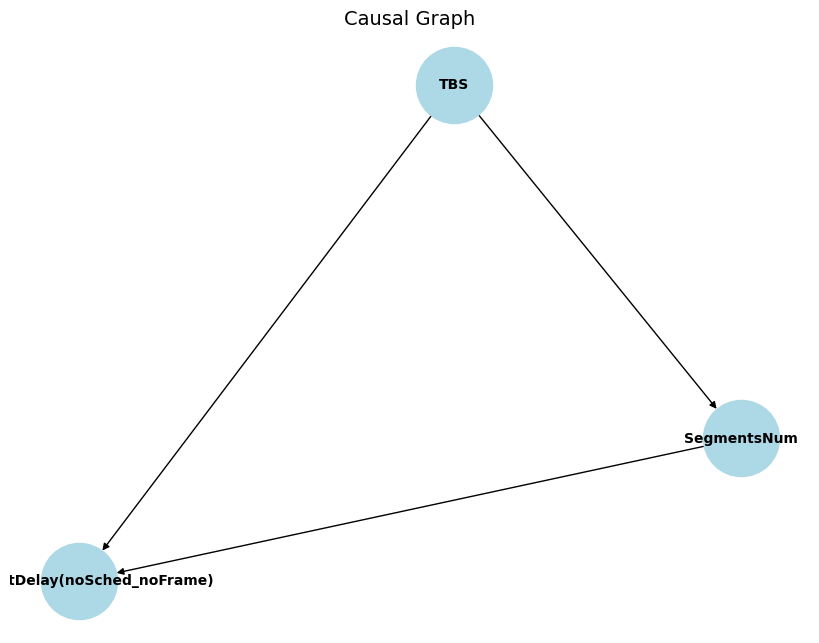

DiGraph with 3 nodes and 3 edges


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the causal graph
causal_graph = nx.DiGraph()

# Add nodes
#causal_graph.add_nodes_from(["PacketSize", "TBS", "SegmentsNum", "SegmentDelay(noSched)"])
causal_graph.add_nodes_from(["TBS", "SegmentsNum", "SegmentDelay(noSched_noFrame)"])
# Add directed edges representing causal relationships
causal_graph.add_edges_from([
    #("PacketSize", "SegmentsNum"),        # Instrument Variable → Treatment
    ("TBS", "SegmentsNum"),               # Confounder → Treatment
    ("TBS", "SegmentDelay(noSched_noFrame)"),     # Confounder → Outcome
    ("SegmentsNum", "SegmentDelay(noSched_noFrame)")  # Treatment → Outcome
])

# Visualize the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(causal_graph, seed=42)  # Layout for better visualization
nx.draw(
    causal_graph, pos, with_labels=True, arrows=True,
    node_size=3000, node_color="lightblue", font_size=10, font_weight="bold"
)
plt.title("Causal Graph", fontsize=14)
nx.write_gml(causal_graph, 'causal_graph_dag.gml')
plt.show()
print(causal_graph)

# 2 Dowhy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
   TBS  SegmentsNum  SegmentDelay(noSched_noFrame)
0   24            1                       6.857872
1   24            3                       9.312153
2   24            1                       9.299278
3   24            3                       5.219698
4   24            2                       7.835150


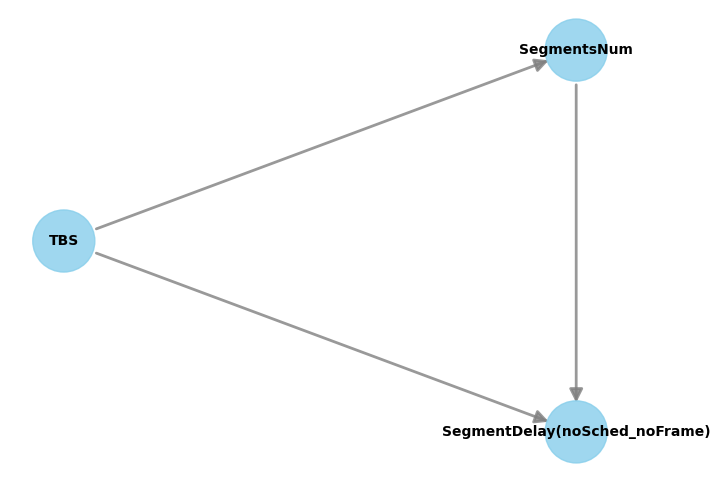

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                             
──────────────(E[SegmentDelay(noSched_noFrame)|TBS])
d[SegmentsNum]                                      
Estimand assumption 1, Unconfoundedness: If U→{SegmentsNum} and U→SegmentDelay(noSched_noFrame) then P(SegmentDelay(noSched_noFrame)|SegmentsNum,TBS,U) = P(SegmentDelay(noSched_noFrame)|SegmentsNum,TBS)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [ ]:
# Libraries and autoreload
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import dowhy
from dowhy import CausalModel
import dowhy.datasets
import warnings
warnings.filterwarnings('ignore')

# Parameters for the dataset
BETA = 10

# Step 1: Generate the dataset
# data = dowhy.datasets.linear_dataset(
#     beta=BETA,
#     num_common_causes=1,  # Adjusted for your causal graph
#     num_samples=100000,     # Smaller sample size for readability
#     #num_instruments=1,    # 1 Instrument Variable: PacketSize
#     num_effect_modifiers=0,
#     num_treatments=1,     # 1 Treatment Variable: SegmentsNum
#     treatment_is_binary=False,
#     num_discrete_common_causes=1,  # Discrete confounders: TBS
#     num_discrete_effect_modifiers=0,
#     one_hot_encode=False
# )

# Extract the dataset
df = pd.read_csv('combined_dataset1.csv')

# Map the variables to your causal graph
df.rename(
    columns={
        "v0": "TBS",                   # Confounder
        #"v1": "PacketSize",            # Instrumental Variable
        "v2": "SegmentsNum",           # Treatment
        "y": "SegmentDelay(noSched_noFrame)"   # Outcome
    },
    inplace=True
)

# Step 2: Define and visualize the causal graph
causal_graph=nx.read_gml("causal_graph_dag.gml")
model = CausalModel(
    data=df,
    treatment="SegmentsNum",
    outcome="SegmentDelay(noSched_noFrame)",
    common_causes=["TBS"],
    graph=causal_graph
)

# Extract the dataframe
df = pd.read_csv('combined_dataset1.csv')

# Print the first few rows of the data
print(df.head())

model.view_model()
# from IPython.display import Image, display
# display(Image(filename="causal_model.png"))
# Print the true causal estimate
# print("True causal estimate is", data["ate"])
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)


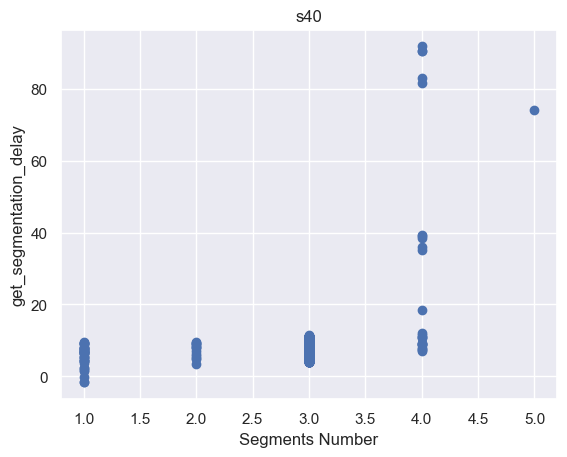

In [ ]:
linear_estimate = model.estimate_effect(identified_estimand,
                    method_name="backdoor.linear_regression",
                    control_value=0,
                    treatment_value=3)
print(linear_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                             
──────────────(E[SegmentDelay(noSched_noFrame)|TBS])
d[SegmentsNum]                                      
Estimand assumption 1, Unconfoundedness: If U→{SegmentsNum} and U→SegmentDelay(noSched_noFrame) then P(SegmentDelay(noSched_noFrame)|SegmentsNum,TBS,U) = P(SegmentDelay(noSched_noFrame)|SegmentsNum,TBS)

## Realized estimand
b: SegmentDelay(noSched_noFrame)~SegmentsNum+TBS
Target units: ate

## Estimate
Mean value: 28.543749930172986



In [ ]:
import dowhy.datasets
import econml
import dowhy
from dowhy import CausalModel
# Remove rows with NaN values
data_cleaned = pd.read_csv('combined_dataset1.csv')

# # Ensure all columns used by DMLIV are numeric and do not contain NaNs or inf
# for col in ["TBS", "SegmentsNum", "SegmentDelay(noSched_noFrame)"]:
#     data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='coerce')
#     data_cleaned = data_cleaned.dropna(subset=[col])
#     data_cleaned = data_cleaned[np.isfinite(data_cleaned[col])]


# Redefine the causal model with the cleaned data
causal_graph=nx.read_gml("causal_graph_dag.gml")
model = CausalModel(
    data=data_cleaned,  # Use cleaned data
    treatment="SegmentsNum",
    outcome="SegmentDelay(noSched_noFrame)",
    common_causes=["TBS"],
    graph=causal_graph
)


# Identify the causal effect in the defined causal model
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

# Estimate the causal effect using the Instrumental Variable Method
dmliv_estimate = model.estimate_effect(
    identified_estimand,
    control_value = 1.0,
    treatment_value = 2.0,
    method_name="backdoor.econml.dml.DML",
    target_units = "att", # Target units condition for your data
    confidence_intervals=False,
    method_params={
        "init_params": {
            'discrete_treatment': True,  # SegmentsNum
            'model_y':GradientBoostingRegressor(),
            'model_t': GradientBoostingClassifier(),
            "model_final":LassoCV(fit_intercept=False),
            'featurizer':PolynomialFeatures(degree=1, include_bias=False)
            },
        "fit_params": {}
    }
)

# Print the estimated causal effect
print("Estimated Causal Effect (DML):")
print(dmliv_estimate)

# IV. Refute the obtained estimate using multiple robustness checks.
refute_results = model.refute_estimate(identified_estimand,
                     dmliv_estimate,
                     method_name="random_common_cause")
print(refute_results)

Estimated Causal Effect (DML):
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                             
──────────────(E[SegmentDelay(noSched_noFrame)|TBS])
d[SegmentsNum]                                      
Estimand assumption 1, Unconfoundedness: If U→{SegmentsNum} and U→SegmentDelay(noSched_noFrame) then P(SegmentDelay(noSched_noFrame)|SegmentsNum,TBS,U) = P(SegmentDelay(noSched_noFrame)|SegmentsNum,TBS)

## Realized estimand
b: SegmentDelay(noSched_noFrame)~SegmentsNum+TBS | 
Target units: att

## Estimate
Mean value: 0.15495678718466654
Effect estimates: [[0.15495679]]

Refute: Add a random common cause
Estimated effect:0.15495678718466654
New effect:0.295427678835873
p value:0.56



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Step 1: Estimate Propensity Scores
# Use logistic regression to estimate the propensity scores (probability of receiving treatment based on confounders)
confounders = ['TBS']  # Confounders that affect both treatment and outcome
X = data_cleaned[confounders]  # Confounders
treatment = data_cleaned['SegmentsNum']  # Treatment variable

# Logistic regression to estimate propensity scores
logreg = LogisticRegression()
logreg.fit(X, treatment)
propensity_scores = logreg.predict_proba(X)[:, 1]  # Get probability of receiving treatment (P(X | C))

# Step 2: Calculate IPW
IPW = 1 / propensity_scores  # Inverse of the propensity scores

# Step 3: Add IPW as a new feature in the dataset
data_cleaned['IPW'] = IPW

# Step 4: Scale the Outcome (SegmentDelay(noSched)) by IPW for CATE
outcome = data_cleaned['SegmentDelay(noSched_noFrame)']
scaled_outcome = outcome * IPW  # Scaling outcome by IPW
